In [ ]:
mdl='Y20F3T2Tka'
p=0.770

In [1]:
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import xarray as xr
from torchvision import transforms
import datetime

#### 数据预处理

1.数据读取

In [2]:
# 定义全局变量
global_time_common = []
#预报与真值时间对齐
def time_union(pre, obs):
    # 转换 DataFrame中的时间格式
    time_1 = pd.to_datetime(pre['time'])
    time_2 = pd.to_datetime(obs['time'])

    # 获取两个DataArray中的时间交集,并排序
    time_common = pd.to_datetime(list(set(time_1).intersection(set(time_2)))).sort_values()
    # print(time_common)
    global global_time_common  # 声明使用全局变量
    global_time_common=time_common
    # print(global_time_common)

    # 检查时间对齐前后的具体时间及维度
    # print(f'time1={time_1}')
    # print(f'time2={time_2}') 
    # print(f'time_cmn={time_common}')
    
    #根据时间交集各自提取对应数据
    pre = pre.loc[time_common]
    obs = obs.loc[time_common]
    return pre, obs, time_common



def read_datasets(fdir=None, tag='train', time_range=None, lat_range=None, lon_range=None, selected_vars=None):
    if fdir is not None:
        path_pre = os.path.join(fdir, f'{tag}_pre50H1H2RnTka509024.nc')
        path_obs = os.path.join(fdir, f'{tag}_obs50rain9024.nc')
    else:
        path_pre = f'{tag}_pre.nc'
        path_obs = f'{tag}_obs.nc'

    # 读取 pre 数据
    with xr.open_dataset(path_pre) as ds_pre:
        pre = ds_pre['data'].sel(
            time=slice(time_range[0], time_range[1]),
            latitude=slice(min(lat_range), max(lat_range)),
            longitude=slice(min(lon_range), max(lon_range))
        ).load()

    # 读取 obs 数据
    with xr.open_dataset(path_obs) as ds_obs:
        obs = ds_obs['data'].sel(
            time=slice(time_range[0], time_range[1]),
            latitude=slice(min(lat_range), max(lat_range)),
            longitude=slice(min(lon_range), max(lon_range))
        ).load()

    # 模式和实况时间对齐
    pre, obs, times_common = time_union(pre, obs)

    # 请在此时间清洗后实现摘取其中不同数量的变量作为输入X重新定义pre，并提取r24h变量作为2次mask判据

    # ==== 新增处理逻辑 ====
    # 1. 提取r24h作为mask判据（从pre中提取）
    mask_r24h = pre.sel(variable='r24h')  # 提取r24h变量
    
    # 2. 根据selected_vars参数选择变量作为新的pre
    if selected_vars is None:
        # 默认选择全部3个变量
        pre_selected = pre
    else:
        # 根据输入列表选择变量
        # 确保选择的变量在pre中实际存在
        valid_vars = [var for var in selected_vars if var in pre.coords['variable'].values]
        if not valid_vars:
            raise ValueError(f"所选变量{selected_vars}在数据集中不存在")
        pre_selected = pre.sel(variable=valid_vars)
    # =====================

    return pre_selected, obs, times_common,mask_r24h

selected_vars=['prev_24h', 'current','r24h','prev_24h1', 'current1','prev_24h2', 'current2']
selected_vars=['prev_24h3', 'current3']

train_pre,train_obs,times_cmn0,train_r24h=read_datasets(fdir='./srdata50/',tag='train',time_range=['2005-1-1T12:00:00','2021-12-31T12:00:00'],
                                  lat_range=[10,55],lon_range=[90,140],selected_vars=selected_vars)  # Now a keyword argument
test_pre,test_obs,times_cmn1,test_r24h=read_datasets(fdir='./srdata50/',tag='test',time_range=['2022-1-1T12:00:00','2024-12-31T12:00:00'],
                                  lat_range=[10,55],lon_range=[90,140],selected_vars=selected_vars)  # Now a keyword argument

print("Train_pre samples:", len(train_pre))  # 检查实际样本数
print("Train_obs samples:", len(train_obs))  # 检查实际样本数
print("Test_pre samples:", len(test_pre))  # 检查实际样本数
print("Test_obs samples:", len(test_obs))  # 检查实际样本数
print(train_pre.shape)
print(train_obs.shape)
count = np.sum(train_obs[0] == 1).item()

print(f'sum1={count}')

# 替换缺测值为NaN并生成掩码
def preprocess_labels(obs_data):
    #print(obs_data[0])  #y值只有0、1和缺测值nan，其中缺测值在同一格点上所有时次都一样为nan
    # 生成初始二维掩码
    mask_2d = ~np.all(np.isnan(obs_data), axis=0)  

    # 扩展为三维掩码
    mask = np.broadcast_to(mask_2d, (len(obs_data), *mask_2d.shape))
    print(mask.shape)
    return obs_data, mask

x_std = train_pre.values.std(axis=(0,1,2))
x_mean = train_pre.values.mean(axis=(0,1,2))

# 只保存输入数据的统计量
std_mean = {
    'x_std': x_std,
    'x_mean': x_mean
    # 移除y相关统计量
}
np.savez('./srsave50/std_mean.npz', **std_mean)

# 转换 xarray.DataArray 为 NumPy 数组
train_pre = train_pre.values  # shape: (样本数, 纬度, 经度, 通道)
test_pre = test_pre.values  # shape: (样本数, 纬度, 经度, 通道)
train_obs,train_mask=preprocess_labels(train_obs)
test_obs,test_mask=preprocess_labels(test_obs)

# 统计缺测格点比例
print(f"掩码类型: {type(train_mask)}, 值范围: {np.unique(train_mask)}")
valid_ratio = train_mask.mean()
print(f"有效格点占比: {valid_ratio:.2%}")

a=np.load('./srsave50/std_mean.npz')
print(a.files)

import numpy as np
import torch
from torch.utils.data import Dataset

import torch
import numpy as np

class GribDataset(torch.utils.data.Dataset):
    def __init__(self, pre, obs, r24h, mask=None, transform=None):
        # 确保所有输入都是numpy数组
        self._pre = pre if isinstance(pre, np.ndarray) else pre.values
        self._obs = obs if isinstance(obs, np.ndarray) else obs.values
        
        # 处理r24h变量
        self._r24h = r24h if isinstance(r24h, np.ndarray) else r24h.values
        
        # 初始掩码：观测值非NaN的位置
        obs_mask = ~np.isnan(self._obs) if mask is None else np.asarray(mask)
        
        # 新增掩码：pre中"r24h"变量不为0的位置
        pre_mask = (self._r24h != 0)  # 非零降水位置
        
        # 组合掩码：同时满足观测有效且降水非零
        self._mask = obs_mask & pre_mask
        # self._mask = obs_mask
        # self._mask = pre_mask        

        # 数据预处理（调整维度顺序）
        self.data = []
        for i in range(len(self._pre)):
            # 将 (H, W, C) 转换为 (C, H, W)
            x = self._pre[i].transpose(2, 0, 1)
            self.data.append(torch.from_numpy(x).float())
            
        self.labels = []
        for i in range(len(self._obs)):
            # 添加通道维度 (H, W) -> (1, H, W)
            y = self._obs[i][np.newaxis, ...]
            self.labels.append(torch.from_numpy(y).float())
            
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs = self.data[idx]
        labels = self.labels[idx]
        
        # 处理掩码（添加通道维度）
        mask_np = self._mask[idx]  # 形状 (H, W)
        mask_np = mask_np[np.newaxis, ...]  # 形状 (1, H, W)
        masks = torch.tensor(mask_np, dtype=torch.float32)        
        
        if self.transform:
            inputs = self.transform(inputs)
            
        return inputs, labels, masks


# 使用时根据数据通道数初始化模型
in_channels = train_pre.shape[-1]  # 获取训练数据的通道数
batch_size=4
kcs=64
iepoch=50
def get_loaders(
    fdir=None,
    tag='train',
    start_time='1990-1-1T12:00:00',
    end_time='2024-12-31T12:00:00',
    transform=None,
    batch_size=batch_size,
    num_works=0,
    pin_memory=True,
    shuffle=True,
):
    '''
        返回loader
        fdir:包含x和y的根目录
        tag:train(训练) or test（测试）
        start_time，endtime:起止时间
        transform:标准化转换器
    '''
    ds = GribDataset(
        fdir=fdir,
        tag=tag,
        start_time=start_time,
        end_time=end_time,
        transform=transform,
    )

    loader =DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_works,
        pin_memory=pin_memory,
        shuffle=shuffle,
    )
    return loader

# 加载std_mean文件
std_mean=np.load('./srsave50/std_mean.npz')

# 定义transforms
transform =transforms.Normalize(
                mean=std_mean['x_mean'],
                std=std_mean['x_std']+1e-8)


# 训练集加载器
train_ds = GribDataset(train_pre, train_obs,train_r24h,train_mask, transform=transform)
print(f'train_samples={len(train_ds)}')
# 检查数据集第一个样本
sample_x, sample_y, sample_z = train_ds[0]
print("Sample x shape:", sample_x.shape)  # 应输出 [1, 91, 101]
print("Sample y shape:", sample_y.shape)  # 应输出 [1, 91, 101]
print("Sample z shape:", sample_z.shape)  # 应输出 [1, 91, 101]

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 测试集加载器
test_ds = GribDataset(test_pre, test_obs,test_r24h,  test_mask,transform=transform)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(f'test_samples={len(test_ds)}')

# 预测集加载器
predict_ds = GribDataset(test_pre, test_obs,test_r24h, test_mask,transform=transform)
predict_loader = DataLoader(test_ds, batch_size=batch_size)

Train_pre samples: 1027
Train_obs samples: 1027
Test_pre samples: 172
Test_obs samples: 172
(1027, 91, 101, 2)
(1027, 91, 101)
sum1=100
(1027, 91, 101)
(172, 91, 101)
掩码类型: <class 'numpy.ndarray'>, 值范围: [False  True]
有效格点占比: 15.00%
['x_std', 'x_mean']
train_samples=1027
Sample x shape: torch.Size([2, 91, 101])
Sample y shape: torch.Size([1, 91, 101])
Sample z shape: torch.Size([1, 91, 101])
test_samples=172


In [19]:
print(f'times0={len(times_cmn0)},{times_cmn0[:5]}')
print(f'times1={len(times_cmn1)},{times_cmn1[:5]}')

times0=1027,DatetimeIndex(['2005-01-08 12:00:00', '2005-01-09 12:00:00',
               '2005-01-11 12:00:00', '2005-02-09 12:00:00',
               '2005-02-10 12:00:00'],
              dtype='datetime64[ns]', freq=None)
times1=172,DatetimeIndex(['2022-06-29 12:00:00', '2022-06-30 12:00:00',
               '2022-07-01 12:00:00', '2022-07-02 12:00:00',
               '2022-07-03 12:00:00'],
              dtype='datetime64[ns]', freq=None)


2.计算数据标准化处理所需的参数（数据量较大时最好保存成文件）

3.加载保存好的标准化参数

#### 定义数据集

#### 定义数据加载器

加载之前计算的均值方差，并定义数据转换器transform，用于数据标准化

构建数据集加载器，用于模型训练或测试的数据加载

In [3]:
# 训练集加载器
train_ds = GribDataset(train_pre, train_obs,train_r24h,train_mask, transform=transform)
print(f'train_samples={len(train_ds)}')
# 检查数据集第一个样本
sample_x, sample_y, sample_z = train_ds[0]
print("Sample x shape:", sample_x.shape)  # 应输出 [1, 91, 101]
print("Sample y shape:", sample_y.shape)  # 应输出 [1, 91, 101]
print("Sample z shape:", sample_z.shape)  # 应输出 [1, 91, 101]

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 测试集加载器
test_ds = GribDataset(test_pre, test_obs, test_r24h, test_mask,transform=transform)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(f'test_samples={len(test_ds)}')

# 预测集加载器
predict_ds = GribDataset(test_pre, test_obs,test_r24h, test_mask,transform=transform)
predict_loader = DataLoader(test_ds, batch_size=batch_size)

train_samples=1027
Sample x shape: torch.Size([2, 91, 101])
Sample y shape: torch.Size([1, 91, 101])
Sample z shape: torch.Size([1, 91, 101])
test_samples=172


构建神经网络，本例采用简化Unet网络，实现格点到格点输出

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        DoubleConv模块，双卷积级联。

        参数：
            in_channels (int): 输入通道数。
            out_channels (int): 输出通道数。

        返回：
            None
        """
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), #卷积，kernel_size=3,stride=1,padding=1,保持尺寸不变
            nn.BatchNorm2d(out_channels), #批标准化
            nn.ReLU(inplace=True), #RELU激活函数
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x) #前向计算


class SimpleUNet(nn.Module):
    def __init__(self, in_chans, out_chans,init_dim=kcs):
        # in_chans (int): 输入通道数。
        # out_chans (int): 输出通道数。
        # init_dim (int, optional): 初始卷积层的维度，默认为64。
             
        super(SimpleUNet, self).__init__()
        # 定义最大池化
        self.pool = nn.MaxPool2d(2, 2)
        # 定义第一层双卷积
        self.conv_down_1 = DoubleConv(in_chans,init_dim)
        # 定义bottleneck
        self.bottleneck = DoubleConv(init_dim, init_dim*2)
        # 定义上采样反卷积层，让尺寸放大2倍
        self.conv_up_1 = nn.ConvTranspose2d(init_dim*2, init_dim, 2,2)
        #定义上采样后的双卷积层
        self.conv_up_1_1 = DoubleConv(init_dim*2, init_dim)
        #定义输出层
        # self.conv_final = nn.Conv2d(init_dim, out_chans,1)
        
        # 添加sigmoid激活
        #self.conv_final = nn.Sequential( nn.Conv2d(init_dim, out_chans, 1), nn.Sigmoid()) 
        self.final = nn.Conv2d(init_dim, 1, kernel_size=1)  # 输出1个通道
        # 如果使用BCEWithLogitsLoss，此处无需sigmoid；否则需要手动加sigmoid
               
    def forward(self, x):
        #第一层卷积计算（含激活和最大池化操作，尺寸缩小为1/2）
        x1 = self.conv_down_1(x)
        x = self.pool(x1)  
        #bottleneck计算
        x = self.bottleneck(x)
        #反卷积进行上采样，并使用激活函数
        x = self.conv_up_1(x)
        #跳跃连接
        if x1.shape != x.shape:
            # 若x的尺寸与x1的不一致，则双线性插值
            x=TF.resize(x,size=x1.shape[2:])
        x = torch.cat([x1, x], dim=1)

        #上采样后再次双卷积运算
        x = self.conv_up_1_1(x)
        # print(x.shape)
        
        #输出层卷积
        # x = self.conv_final(x)
        # return x
        
        # #... 前向传播 ...
        x= self.final(x)  # 输出logits（未归一化的概率）
        x = x.squeeze(1)  # 移除通道维度 → 形状 (B, H, W)
        return x
       

In [5]:
#实例化一个网络,确保输入和输出的通道保持一致

net = SimpleUNet(in_chans=in_channels,out_chans=1)



构建训练所需组件，优化器，损失函数：

In [6]:
import torch.optim as optim

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#定义损失函数和优化器
# criterion =nn.CrossEntropyLoss() #交叉熵
# criterion = nn.BCEWithLogitsLoss()  # 二值交叉熵损失  逐格点（像素）二分类（每个网格点独立预测 0 或 1）
criterion = nn.BCEWithLogitsLoss(reduction='none')  # 改为逐元素计算
optimizer = optim.Adam(net.parameters(), lr=0.001) #使用Adam优化器，学习率为0.001

构建验证评估方法，此处直接采用MAE作为评估指标

In [7]:
def test(net, test_loader, criterion):
    net.eval()
    total_valid_loss = 0.0
    total_valid_pixels = 0
    TP_total, FN_total, TN_total, FP_total = 0, 0, 0, 0  # 累计全局统计量

    with torch.no_grad():
        for inputs, labels, masks in test_loader:
            inputs, labels, masks = inputs.to(device), labels.to(device), masks.to(device)
            
            # 前向传播并调整形状
            outputs = net(inputs).squeeze(1)  # 输出形状 (B, H, W)
            labels = labels.squeeze(1)        # 确保形状一致 (B, H, W)
            masks = masks.squeeze(1).bool()   # 转换为布尔掩码 (B, H, W)

            # 提取有效像素（一维张量）
            valid_outputs = outputs.masked_select(masks)
            valid_labels = labels.masked_select(masks)
            
            # 计算损失
            valid_loss = F.binary_cross_entropy_with_logits(valid_outputs, valid_labels, reduction="sum")
            total_valid_loss += valid_loss.item()
            total_valid_pixels += masks.sum().item()

            # 二值化预测
            preds = (torch.sigmoid(valid_outputs) > 0.5).float()
            
            # 计算混淆矩阵元素（当前批次）
            TP = torch.sum((valid_labels == 1) & (preds == 1)).item()
            FN = torch.sum((valid_labels == 1) & (preds == 0)).item()
            TN = torch.sum((valid_labels == 0) & (preds == 0)).item()
            FP = torch.sum((valid_labels == 0) & (preds == 1)).item()
            
            # 累加全局统计
            TP_total += TP
            FN_total += FN
            TN_total += TN
            FP_total += FP

            # print(f'TP={TP}  FN={FN}  TN={TN}  FP={FP}')

    # 全局指标计算
    avg_loss = total_valid_loss / total_valid_pixels if total_valid_pixels > 0 else 0
    total = TP_total + FN_total + FP_total  # 分母
    
    CrtRto = TP_total / total
    AcrCrt = f'{TP_total / total:.1%}' if total > 0 else "0.0%"
    AcrFls = f'{FP_total / total:.1%}' if total > 0 else "0.0%"
    AcrMss = f'{FN_total / total:.1%}' if total > 0 else "0.0%"



    print(f'                CEL loss: {avg_loss:.4f}')
    print(f'                  Accuracy: CRT: {AcrCrt}   MSS: {AcrMss}  FLS: {AcrFls}')

    return avg_loss, CrtRto

In [8]:
import warnings

# 忽略特定 UserWarning
warnings.filterwarnings(
    "ignore",
    message="The default value of the antialias parameter of all the resizing transforms...",
    category=UserWarning
)

构建训练流程

In [26]:
import os
import time
from tqdm import tqdm

# 创建保存目录（如果不存在）
os.makedirs('./srsave50', exist_ok=True)

def compute_masked_loss(outputs, labels, mask):
    # 确保 mask 是布尔张量且与 outputs/labels 在同一设备
    mask = mask.bool().to(outputs.device)
    
    # 使用 PyTorch 的 masked_select 过滤无效点
    valid_outputs = outputs.masked_select(mask)
    valid_labels = labels.masked_select(mask)
    
    # 计算损失（例如 BCEWithLogitsLoss）
    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        valid_outputs, valid_labels, reduction="mean"
    )
    return loss

start = time.time()
print('start to train')
loss_ls = []
test_ls = []
best_cel = float('inf')  # 初始化最佳测试损失为无穷大

cr0 = 0
for epoch in range(iepoch):
    # --- 训练阶段 ---
    net.train()
    running_loss = 0.0
    for inputs, labels, masks in tqdm(train_loader):  # 接收 masks
        inputs, labels, masks = inputs.to(device), labels.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)

        labels=labels.squeeze(1)
        masks=masks.squeeze(1)
        # print(f"outputs.shape: {outputs.shape}")  # 应为 (B,H,W)
        # print(f"labels.shape: {labels.shape}")    # 应为 (B,H,W)
        # print(f"masks.shape: {masks.shape}")      # 应为 (B,H,W)        
        
        # 使用修正后的损失计算
        loss = compute_masked_loss(outputs, labels, masks)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    loss_ls.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{iepoch}] Train Loss: {epoch_loss:.4f}')

    current_cel, CrtRto = test(net, test_loader, criterion)
    test_ls.append(current_cel)


    # 在训练时选择测试最佳效果模型保存
    if CrtRto > cr0:
        if (cr0 == 0) : 
            timestamp = datetime.datetime.now().strftime("%y%m%d%H%M")
        model_save_path = f'./srsave/{mdl}{timestamp}.pth'
        torch.save(net.state_dict(), model_save_path)
        print(f'                     Model saved to {model_save_path}')
        cr0=CrtRto


print('Finished Training! Total time: {:.2f}s'.format(time.time() - start))

start to train


100%|██████████| 257/257 [01:08<00:00,  3.73it/s]


Epoch [1/50] Train Loss: 0.3941
                CEL loss: 0.2846
                  Accuracy: CRT: 65.7%   MSS: 27.9%  FLS: 6.4%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:05<00:00,  3.95it/s]


Epoch [2/50] Train Loss: 0.3382
                CEL loss: 0.3815
                  Accuracy: CRT: 50.5%   MSS: 9.2%  FLS: 40.3%


100%|██████████| 257/257 [01:06<00:00,  3.89it/s]


Epoch [3/50] Train Loss: 0.3239
                CEL loss: 0.2386
                  Accuracy: CRT: 71.9%   MSS: 18.9%  FLS: 9.3%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:04<00:00,  3.97it/s]


Epoch [4/50] Train Loss: 0.3138
                CEL loss: 0.2370
                  Accuracy: CRT: 70.9%   MSS: 19.1%  FLS: 10.1%


100%|██████████| 257/257 [01:05<00:00,  3.94it/s]


Epoch [5/50] Train Loss: 0.3068
                CEL loss: 0.2302
                  Accuracy: CRT: 72.3%   MSS: 14.7%  FLS: 13.0%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:04<00:00,  3.97it/s]


Epoch [6/50] Train Loss: 0.2954
                CEL loss: 0.2266
                  Accuracy: CRT: 73.0%   MSS: 12.7%  FLS: 14.3%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:05<00:00,  3.95it/s]


Epoch [7/50] Train Loss: 0.3075
                CEL loss: 0.2613
                  Accuracy: CRT: 66.8%   MSS: 14.5%  FLS: 18.7%


100%|██████████| 257/257 [01:05<00:00,  3.94it/s]


Epoch [8/50] Train Loss: 0.2837
                CEL loss: 0.2112
                  Accuracy: CRT: 73.9%   MSS: 17.7%  FLS: 8.4%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:04<00:00,  4.00it/s]


Epoch [9/50] Train Loss: 0.2893
                CEL loss: 0.2255
                  Accuracy: CRT: 73.7%   MSS: 17.6%  FLS: 8.7%


100%|██████████| 257/257 [01:04<00:00,  3.98it/s]


Epoch [10/50] Train Loss: 0.2851
                CEL loss: 0.2469
                  Accuracy: CRT: 70.9%   MSS: 19.5%  FLS: 9.6%


100%|██████████| 257/257 [01:04<00:00,  4.01it/s]


Epoch [11/50] Train Loss: 0.2854
                CEL loss: 0.2056
                  Accuracy: CRT: 73.9%   MSS: 16.2%  FLS: 9.9%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:03<00:00,  4.04it/s]


Epoch [12/50] Train Loss: 0.2746
                CEL loss: 0.2075
                  Accuracy: CRT: 75.8%   MSS: 12.3%  FLS: 11.9%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:04<00:00,  3.97it/s]


Epoch [13/50] Train Loss: 0.2651
                CEL loss: 0.2185
                  Accuracy: CRT: 74.2%   MSS: 14.9%  FLS: 10.9%


100%|██████████| 257/257 [01:06<00:00,  3.84it/s]


Epoch [14/50] Train Loss: 0.2736
                CEL loss: 0.2076
                  Accuracy: CRT: 74.7%   MSS: 15.5%  FLS: 9.8%


100%|██████████| 257/257 [01:03<00:00,  4.02it/s]


Epoch [15/50] Train Loss: 0.2724
                CEL loss: 0.2139
                  Accuracy: CRT: 74.3%   MSS: 11.9%  FLS: 13.8%


100%|██████████| 257/257 [01:04<00:00,  3.97it/s]


Epoch [16/50] Train Loss: 0.2688
                CEL loss: 0.2020
                  Accuracy: CRT: 74.3%   MSS: 17.3%  FLS: 8.4%


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


Epoch [17/50] Train Loss: 0.2612
                CEL loss: 0.2181
                  Accuracy: CRT: 72.7%   MSS: 14.5%  FLS: 12.7%


100%|██████████| 257/257 [01:11<00:00,  3.59it/s]


Epoch [18/50] Train Loss: 0.2520
                CEL loss: 0.1956
                  Accuracy: CRT: 74.1%   MSS: 15.8%  FLS: 10.2%


100%|██████████| 257/257 [01:37<00:00,  2.64it/s]


Epoch [19/50] Train Loss: 0.2666
                CEL loss: 0.2204
                  Accuracy: CRT: 73.4%   MSS: 19.1%  FLS: 7.4%


100%|██████████| 257/257 [01:42<00:00,  2.50it/s]


Epoch [20/50] Train Loss: 0.2576
                CEL loss: 0.1856
                  Accuracy: CRT: 76.5%   MSS: 12.6%  FLS: 10.9%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:40<00:00,  2.55it/s]


Epoch [21/50] Train Loss: 0.2554
                CEL loss: 0.1947
                  Accuracy: CRT: 75.5%   MSS: 16.3%  FLS: 8.2%


100%|██████████| 257/257 [01:40<00:00,  2.55it/s]


Epoch [22/50] Train Loss: 0.2588
                CEL loss: 0.1950
                  Accuracy: CRT: 76.0%   MSS: 14.5%  FLS: 9.4%


100%|██████████| 257/257 [01:40<00:00,  2.56it/s]


Epoch [23/50] Train Loss: 0.2548
                CEL loss: 0.1942
                  Accuracy: CRT: 74.2%   MSS: 17.8%  FLS: 8.0%


100%|██████████| 257/257 [01:41<00:00,  2.53it/s]


Epoch [24/50] Train Loss: 0.2487
                CEL loss: 0.1869
                  Accuracy: CRT: 76.1%   MSS: 13.2%  FLS: 10.6%


100%|██████████| 257/257 [01:39<00:00,  2.58it/s]


Epoch [25/50] Train Loss: 0.2516
                CEL loss: 0.2068
                  Accuracy: CRT: 75.4%   MSS: 12.3%  FLS: 12.3%


100%|██████████| 257/257 [01:42<00:00,  2.51it/s]


Epoch [26/50] Train Loss: 0.2458
                CEL loss: 0.1857
                  Accuracy: CRT: 74.9%   MSS: 17.0%  FLS: 8.1%


100%|██████████| 257/257 [01:40<00:00,  2.55it/s]


Epoch [27/50] Train Loss: 0.2495
                CEL loss: 0.2023
                  Accuracy: CRT: 75.3%   MSS: 12.4%  FLS: 12.2%


100%|██████████| 257/257 [01:40<00:00,  2.56it/s]


Epoch [28/50] Train Loss: 0.2363
                CEL loss: 0.1861
                  Accuracy: CRT: 75.6%   MSS: 16.4%  FLS: 8.0%


100%|██████████| 257/257 [01:39<00:00,  2.58it/s]


Epoch [29/50] Train Loss: 0.2396
                CEL loss: 0.2068
                  Accuracy: CRT: 74.4%   MSS: 13.3%  FLS: 12.3%


100%|██████████| 257/257 [01:36<00:00,  2.67it/s]


Epoch [30/50] Train Loss: 0.2388
                CEL loss: 0.1955
                  Accuracy: CRT: 75.1%   MSS: 15.5%  FLS: 9.4%


100%|██████████| 257/257 [01:21<00:00,  3.14it/s]


Epoch [31/50] Train Loss: 0.2360
                CEL loss: 0.1864
                  Accuracy: CRT: 76.7%   MSS: 12.9%  FLS: 10.5%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:09<00:00,  3.71it/s]


Epoch [32/50] Train Loss: 0.2395
                CEL loss: 0.2050
                  Accuracy: CRT: 75.6%   MSS: 11.1%  FLS: 13.3%


100%|██████████| 257/257 [01:01<00:00,  4.17it/s]


Epoch [33/50] Train Loss: 0.2287
                CEL loss: 0.1980
                  Accuracy: CRT: 75.0%   MSS: 11.7%  FLS: 13.2%


100%|██████████| 257/257 [01:05<00:00,  3.91it/s]


Epoch [34/50] Train Loss: 0.2296
                CEL loss: 0.1880
                  Accuracy: CRT: 75.0%   MSS: 15.6%  FLS: 9.5%


100%|██████████| 257/257 [01:08<00:00,  3.73it/s]


Epoch [35/50] Train Loss: 0.2338
                CEL loss: 0.1942
                  Accuracy: CRT: 74.2%   MSS: 16.9%  FLS: 9.0%


100%|██████████| 257/257 [01:09<00:00,  3.70it/s]


Epoch [36/50] Train Loss: 0.2277
                CEL loss: 0.1868
                  Accuracy: CRT: 77.0%   MSS: 10.6%  FLS: 12.5%
                     Model saved to ./srsave/Y20F3T2Tkd2507151100.pth


100%|██████████| 257/257 [01:09<00:00,  3.71it/s]


Epoch [37/50] Train Loss: 0.2271
                CEL loss: 0.1842
                  Accuracy: CRT: 76.0%   MSS: 11.5%  FLS: 12.5%


100%|██████████| 257/257 [01:09<00:00,  3.71it/s]


Epoch [38/50] Train Loss: 0.2253
                CEL loss: 0.1837
                  Accuracy: CRT: 76.0%   MSS: 15.0%  FLS: 9.0%


100%|██████████| 257/257 [01:09<00:00,  3.72it/s]


Epoch [39/50] Train Loss: 0.2338
                CEL loss: 0.1927
                  Accuracy: CRT: 75.8%   MSS: 14.0%  FLS: 10.2%


100%|██████████| 257/257 [01:09<00:00,  3.71it/s]


Epoch [40/50] Train Loss: 0.2282
                CEL loss: 0.1992
                  Accuracy: CRT: 75.5%   MSS: 10.9%  FLS: 13.7%


100%|██████████| 257/257 [01:08<00:00,  3.74it/s]


Epoch [41/50] Train Loss: 0.2246
                CEL loss: 0.1772
                  Accuracy: CRT: 76.6%   MSS: 11.4%  FLS: 11.9%


100%|██████████| 257/257 [01:09<00:00,  3.70it/s]


Epoch [42/50] Train Loss: 0.2185
                CEL loss: 0.1884
                  Accuracy: CRT: 74.3%   MSS: 13.9%  FLS: 11.8%


100%|██████████| 257/257 [01:08<00:00,  3.74it/s]


Epoch [43/50] Train Loss: 0.2310
                CEL loss: 0.1852
                  Accuracy: CRT: 76.1%   MSS: 11.7%  FLS: 12.2%


100%|██████████| 257/257 [01:08<00:00,  3.74it/s]


Epoch [44/50] Train Loss: 0.2147
                CEL loss: 0.1955
                  Accuracy: CRT: 74.6%   MSS: 15.8%  FLS: 9.6%


100%|██████████| 257/257 [01:10<00:00,  3.66it/s]


Epoch [45/50] Train Loss: 0.2111
                CEL loss: 0.1936
                  Accuracy: CRT: 75.4%   MSS: 15.2%  FLS: 9.4%


100%|██████████| 257/257 [01:09<00:00,  3.69it/s]


Epoch [46/50] Train Loss: 0.2155
                CEL loss: 0.1875
                  Accuracy: CRT: 74.6%   MSS: 14.6%  FLS: 10.7%


100%|██████████| 257/257 [01:09<00:00,  3.68it/s]


Epoch [47/50] Train Loss: 0.2218
                CEL loss: 0.1979
                  Accuracy: CRT: 73.2%   MSS: 13.9%  FLS: 12.9%


100%|██████████| 257/257 [01:07<00:00,  3.78it/s]


Epoch [48/50] Train Loss: 0.2145
                CEL loss: 0.1821
                  Accuracy: CRT: 76.1%   MSS: 12.9%  FLS: 11.1%


100%|██████████| 257/257 [01:05<00:00,  3.91it/s]


Epoch [49/50] Train Loss: 0.2081
                CEL loss: 0.1897
                  Accuracy: CRT: 75.4%   MSS: 14.9%  FLS: 9.7%


100%|██████████| 257/257 [01:05<00:00,  3.91it/s]


Epoch [50/50] Train Loss: 0.2129
                CEL loss: 0.1879
                  Accuracy: CRT: 74.3%   MSS: 16.6%  FLS: 9.1%
Finished Training! Total time: 3978.27s


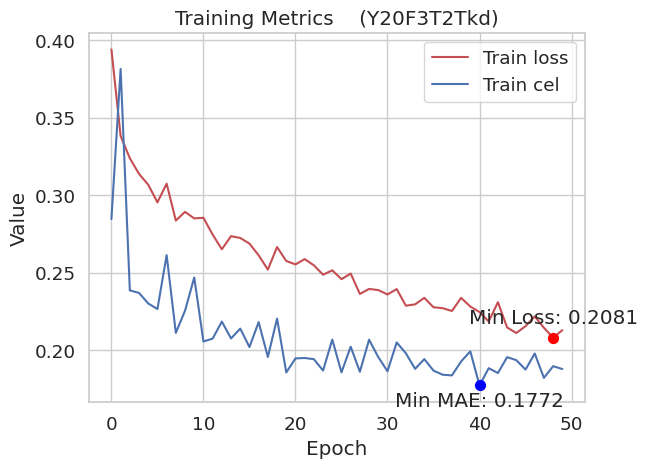

In [27]:
import matplotlib.pyplot as plt
import numpy as np  # 需要添加numpy库
from datetime import datetime

# 绘制训练曲线
plt.plot(loss_ls, 'r', label='Train loss')
plt.plot(test_ls, 'b', label='Train cel')

# 找到并标注loss最低点
min_loss_idx = np.argmin(loss_ls)
min_loss = loss_ls[min_loss_idx]
plt.scatter(min_loss_idx, min_loss, c='red', s=50, zorder=3)
plt.annotate(f'Min Loss: {min_loss:.4f}', 
             (min_loss_idx, min_loss),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')

# 找到并标注cel最低点
min_cel_idx = np.argmin(test_ls)
min_cel = test_ls[min_cel_idx]
plt.scatter(min_cel_idx, min_cel, c='blue', s=50, zorder=3)
plt.annotate(f'Min MAE: {min_cel:.4f}',
             (min_cel_idx, min_cel),
             textcoords="offset points",
             xytext=(0,-15),
             ha='center')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')

fn=f'c{in_channels}b{batch_size}k{kcs}'
plt.title(f'Training Metrics    ({mdl})')
plt.savefig(f'sr50figs\\{fn}T{timestamp}.jpg') 
plt.show()


输出模型识别结果Matrix矩阵图形

Successfully loaded model from ./srsave/Y20F3T2Tka2507151100.pth
Test Accuracy: 0.9351


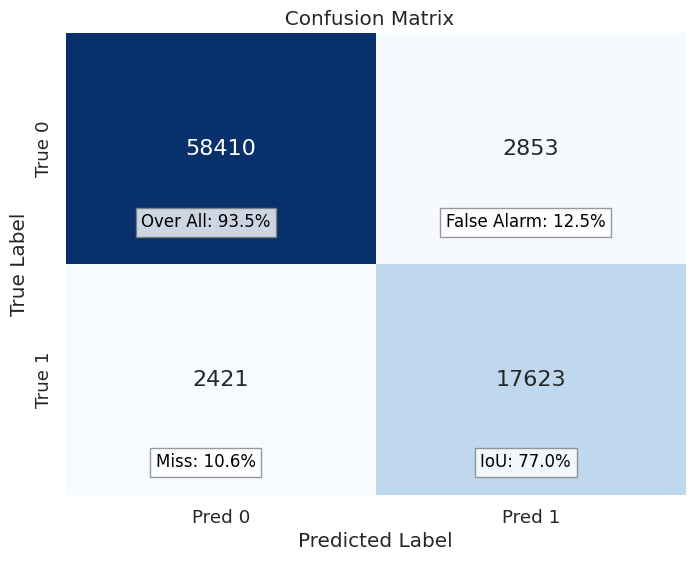

In [18]:
model_save_path='./srsave/Y20F3T2Tka2507151100.pth'
# 添加模型加载函数
def load_model(model, model_path):
    """加载保存的模型参数
    参数：
        model : 模型实例
        model_path : 模型保存路径
    返回：
        加载参数后的模型
    """
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f'Successfully loaded model from {model_path}')
    else:
        print(f'Warning: Model file {model_path} not found!')
    return model

# 加载模型（无std_mean）
pred_net = SimpleUNet(in_chans=in_channels,out_chans=1)  # 替换为你的模型类
pred_net = load_model(pred_net, model_save_path)

def predict(net, test_loader):
    net.eval()
    total_correct = 0
    total_valid_pixels = 0
    predss = []
    truths = []
    all_masks = []  # 新增：收集所有掩码
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, masks = data
            outputs = net(inputs)
            
            # 二分类处理
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            # 统一处理维度：移除通道维度 (B, 1, H, W) -> (B, H, W)
            preds = preds.squeeze(1)  # 移除通道维度
            labels = labels.squeeze(1)  # 移除通道维度
            
            # 确保masks维度匹配 (B, H, W)
            masks = masks.squeeze(1) if masks.dim() == 4 else masks
            
            # 转换到相同设备
            masks = masks.bool().to(preds.device)
            valid_pixels = masks.sum().item()
            
            # 计算准确率
            correct = ((preds == labels) & masks).sum().item()
            total_correct += correct
            total_valid_pixels += valid_pixels

            # 收集结果（保持三维结构）
            predss.append(preds.cpu().numpy())
            truths.append(labels.cpu().numpy())
            all_masks.append(masks.cpu().numpy())  # 新增：收集掩码
    
    # 计算全局准确率
    accuracy = total_correct / total_valid_pixels if total_valid_pixels > 0 else 0
    
    # 沿批次维度拼接
    return accuracy, np.concatenate(predss), np.concatenate(truths), np.concatenate(all_masks)  # 返回掩码

# 执行预测
accuracy, predictions, ground_truth, test_mask = predict(pred_net, predict_loader)
print(f"Test Accuracy: {accuracy:.4f}")

# 展平数据为 1D 并应用掩码
ground_truth_flat = ground_truth.flatten()
predictions_flat = predictions.flatten()
mask_flat = test_mask.flatten()  # 使用预测函数返回的掩码

# 仅保留有效像素
valid_indices = mask_flat
valid_ground_truth = ground_truth_flat[valid_indices]
valid_predictions = predictions_flat[valid_indices]

# 计算IoU相关指标
TP = np.sum((valid_ground_truth == 1) & (valid_predictions == 1))
FN = np.sum((valid_ground_truth == 1) & (valid_predictions == 0))
FP = np.sum((valid_ground_truth == 0) & (valid_predictions == 1))
TN = np.sum((valid_ground_truth == 0) & (valid_predictions == 0))

# 计算IoU分母（仅台风降水相关点）
denominator = TP + FN + FP

# 计算各项指标（使用IoU分母）
if denominator > 0:
    AcrAct = TP / denominator
    AcrFls = FP / denominator
    AcrMis = FN / denominator
else:
    AcrAct = AcrFls = AcrMis = 0.0

# 输出详细统计信息
# print(f"TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}")
# print(f"IoU Denominator (TP+FN+FP): {denominator}")
# print(f"AcrAct: {AcrAct:.1%}, AcrMis: {AcrMis:.1%}, AcrFls: {AcrFls:.1%}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np

AcrAct=f'{TP/(TP+FN+FP):.1%}'
AcrFls=f'{FP/(TP+FN+FP):.1%}'
AcrMis=f'{FN/(TP+FN+FP):.1%}'

# 输出结果
# print(f"""
# Accuracy ratio:
# Acr_Act: {AcrAct}
# Acr_Mis: {AcrMis}
# Acr_Fls: {AcrFls}
# """)

# 过滤异常值（如有）
valid_ground_truth = valid_ground_truth[valid_ground_truth >= 0]
valid_predictions = valid_predictions[valid_ground_truth >= 0]

# 设置绘图风格
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'DejaVu Sans'  # 解决中文乱码问题（根据系统字体调整）

# # 使用有效像素数据绘图
# plot_confusion_matrix(valid_ground_truth, valid_predictions)
def plot_confusion_matrix(y_true, y_pred, AcrAct, AcrMis, AcrFls):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))  # 调整画布大小以适应统计值
    
    # 绘制热图并获取坐标轴对象
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    cbar=False, annot_kws={"size": 16},
                    xticklabels=['Pred 0', 'Pred 1'], 
                    yticklabels=['True 0', 'True 1'])
    
   
    # ========== 新增2：添加统计值标注 ==========
    stats_text0 = (f'Over All: {accuracy:.1%}')
    stats_text1 = (f'IoU: {AcrAct}')
    stats_text2 = (f'Miss: {AcrMis}')
    stats_text3 = (f'False Alarm: {AcrFls}')
    
    # 将统计值放在图下方（使用figure坐标，0是左下，1是右上）
    plt.figtext(0.3, 0.55, stats_text0, ha='center', va='bottom', fontsize=12, color='black',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'))
    plt.figtext(0.7, 0.15, stats_text1, ha='center', va='bottom', fontsize=12, color='black',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'))
    plt.figtext(0.3, 0.15, stats_text2, ha='center', va='bottom', fontsize=12, color='black',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'))
    plt.figtext(0.7, 0.55, stats_text3, ha='center', va='bottom', fontsize=12, color='black',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'))
    
    # 调整标题和标签
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
#     plt.title(f' {mdl}         Confusion Matrix       Gross: {accuracy:.1%}')
    plt.title(f'          Confusion Matrix            ')
    
    # 确保保存路径存在
    # plt.savefig(f'sr50figs/mtrx{mdl}T{timestamp}.jpg', bbox_inches='tight')  # 使用正斜杠兼容路径
    plt.show()

# 调用时传入统计值参数
plot_confusion_matrix(valid_ground_truth, valid_predictions, AcrAct, AcrMis, AcrFls)

输出测试样本专家分析真值与模型识别结果对比图

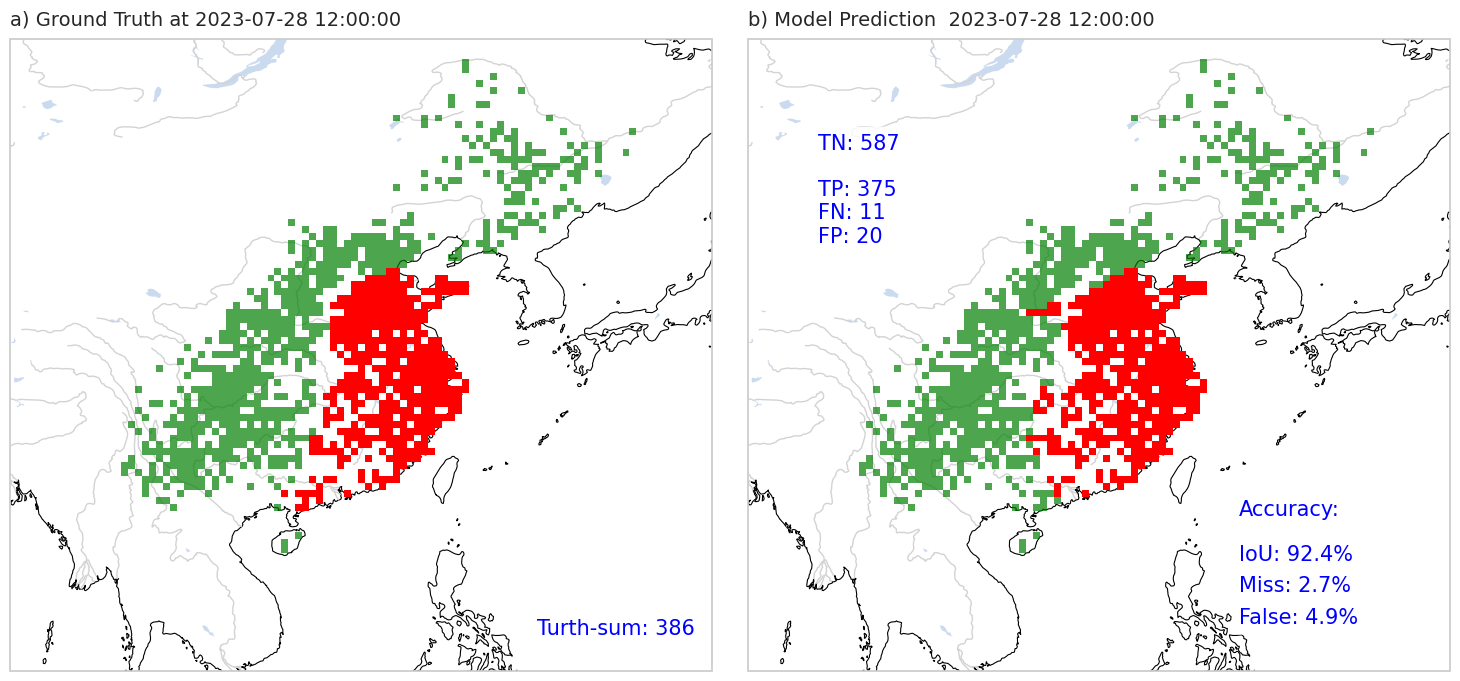

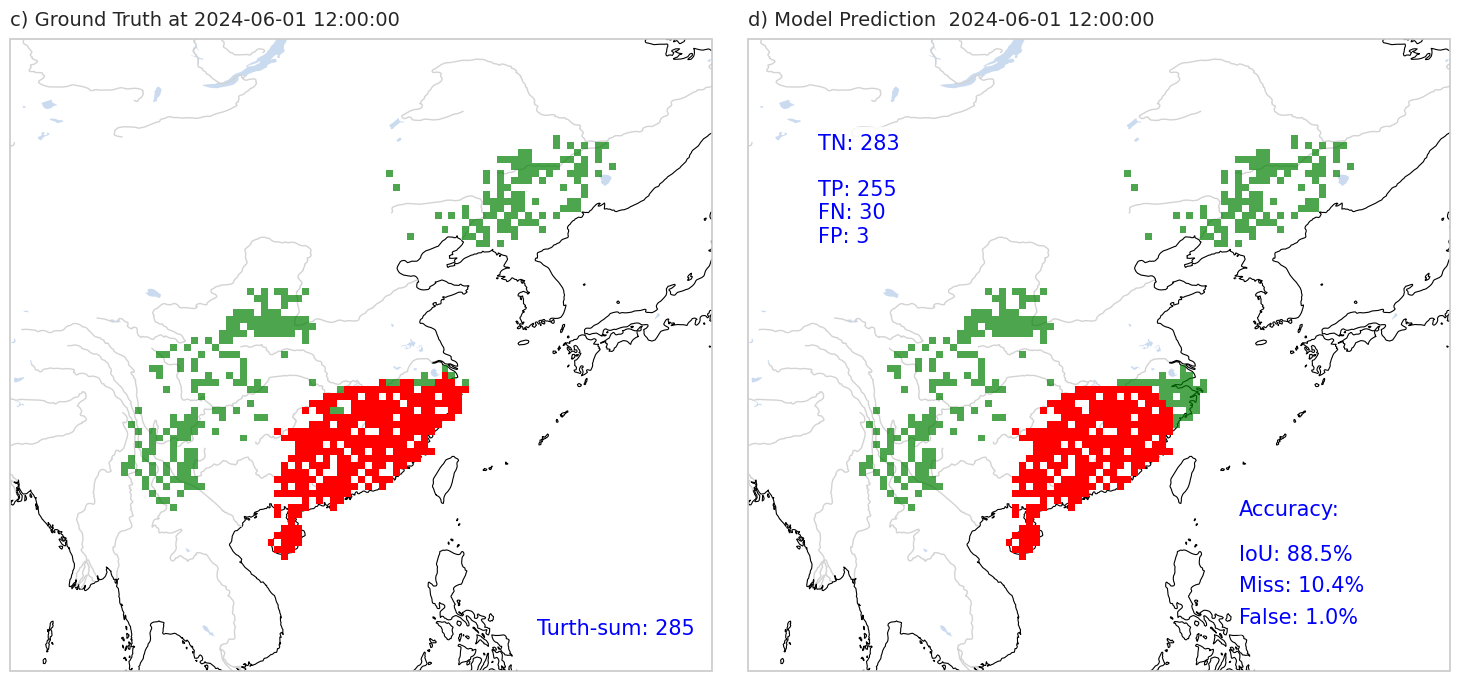

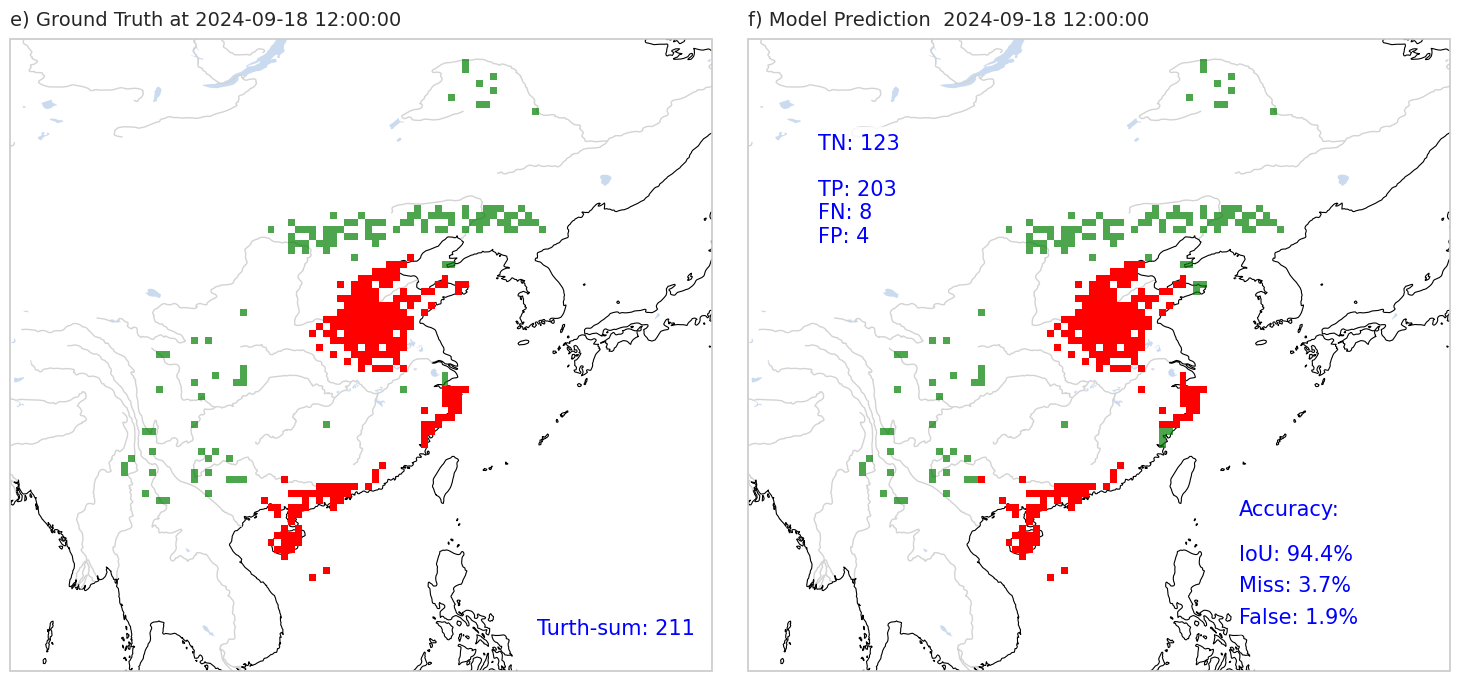

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
import os
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_forecast_comparison(ground_truth, prediction, precipitation, timestamp, mask=None, lon=None, lat=None):
    # === 新增：确保所有输入都是 NumPy 数组 ===
    ground_truth = np.asarray(ground_truth)
    prediction = np.asarray(prediction)
    precipitation = np.asarray(precipitation)
    if mask is not None:
        mask = np.asarray(mask)
    
    """
    绘制指定时次的实况与预报对比图
    参数：
        ground_truth : 实况数据 (H, W)
        prediction : 预报数据 (H, W)
        precipitation : 降水数据 (H, W)
        timestamp : 时间标识字符串（如"2024-07-26T12:00"）
        mask : 掩膜数据 (H, W)
    """
    # 创建带地理坐标的子图 - 调整尺寸使图像更大
    fig = plt.figure(figsize=(16, 8))
    proj = ccrs.PlateCarree()  # 使用经纬度坐标系
    
    # 确保经纬度数据有效
    if lon is None or lat is None or np.isnan(lon).any() or np.isnan(lat).any():
        lon_min, lon_max = 0, 1
        lat_min, lat_max = 0, 1
    else:
        lon_min = np.nanmin(lon)
        lon_max = np.nanmax(lon)
        lat_min = np.nanmin(lat)
        lat_max = np.nanmax(lat)
        
        # 确保范围有效
        if np.isinf(lon_min) or np.isinf(lon_max) or np.isinf(lat_min) or np.isinf(lat_max):
            lon_min, lon_max = 0, 1
            lat_min, lat_max = 0, 1
    
    # 处理掩膜（可选）
    if mask is not None:
        ground_truth = np.ma.masked_where(~mask, ground_truth)
        prediction = np.ma.masked_where(~mask, prediction)
        precipitation = np.ma.masked_where(~mask, precipitation)

    TT = np.sum(ground_truth == 1)        
    
    # 创建自定义颜色映射
    precip_cmap = mcolors.ListedColormap(['lightgray', 'green'])
    precip_norm = mcolors.BoundaryNorm([0, 0.5, 100], precip_cmap.N)
    
    event_cmap = mcolors.ListedColormap(['none', 'red'])
    event_norm = mcolors.BoundaryNorm([0, 0.5, 1], event_cmap.N)

    # 绘制实况图
    ax1 = fig.add_subplot(121, projection=proj)
    
    # 设置地图范围
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
    
    # 1. 先绘制地理特征（设置zorder=1确保在底层）
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=1)
    ax1.add_feature(cfeature.LAKES, alpha=0.5, zorder=1)
    ax1.add_feature(cfeature.RIVERS, edgecolor='lightgrey', zorder=1)

    # 2. 绘制降水背景（zorder=2，在地理特征上方）
    img_precip1 = ax1.imshow(precipitation, origin='lower', 
                            extent=[lon_min, lon_max, lat_min, lat_max],
                            cmap=precip_cmap, norm=precip_norm, 
                            alpha=0.7,  # 保留透明度
                            transform=proj,
                            zorder=2)  # 明确设置zorder

    # 3. 绘制实况数据（最顶层，zorder=3）
    img_truth = ax1.imshow(ground_truth, origin='lower', 
                        extent=[lon_min, lon_max, lat_min, lat_max],
                        cmap=event_cmap, norm=event_norm, 
                        transform=proj,
                        zorder=3)  # 顶层数据

    tb = ""
    time_labels = {
        "2023-07-28 12:00:00": "a)",
        "2024-06-01 12:00:00": "c)",
        "2024-09-18 12:00:00": "e)"
    }
    tb = time_labels.get(timestamp, "")

    ax1.set_title(f'{tb} Ground Truth at {timestamp}', fontsize=14, loc='left', pad=10)
    ax1.text(0.75, 0.05, f'Turth-sum: {TT}', transform=ax1.transAxes,
            fontsize=15, verticalalignment='bottom',color='blue', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    


    # 绘制预报图
    ax2 = fig.add_subplot(122, projection=proj)
    
    # 设置地图范围
    ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
    
    # 添加地理特征
    ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
    # ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax2.add_feature(cfeature.LAKES, alpha=0.5,zorder=1)
    ax2.add_feature(cfeature.RIVERS, edgecolor='lightgrey',zorder=1)
    
  
    # 先绘制降水背景
    img_precip2 = ax2.imshow(precipitation, origin='lower', 
                            extent=[lon_min, lon_max, lat_min, lat_max],
                            cmap=precip_cmap, norm=precip_norm, 
                            alpha=0.7, transform=proj,zorder=2)
    
    # 再绘制预报数据
    img_pred = ax2.imshow(prediction, origin='lower', 
                         extent=[lon_min, lon_max, lat_min, lat_max],
                         cmap=event_cmap, norm=event_norm, 
                         transform=proj,zorder=3)
    
    tb = ""
    time_labels = {
        "2023-07-28 12:00:00": "b)",
        "2024-06-01 12:00:00": "d)",
        "2024-09-18 12:00:00": "f)"
    }
    tb = time_labels.get(timestamp, "")
    ax2.set_title(f'{tb} Model Prediction  {timestamp}', fontsize=14, loc='left', pad=10)

    # # 添加公共色标
    # cbar_ax = fig.add_axes([0.15, 0.05, 0.3, 0.03])  # 调整位置到图像下方
    # plt.colorbar(img_precip1, cax=cbar_ax, orientation='horizontal', 
    #              label='Precipitation (Gray: 0, Green: >0)', ticks=[0, 1])
    # cbar_ax.xaxis.set_ticks_position('bottom')

    # === 修改：使用 .ravel() 替代 .flatten() ===
    ground_truth_flat = ground_truth.ravel()  # 使用 .ravel()
    predictions_flat = prediction.ravel()     # 使用 .ravel()
    precipitation_flat = precipitation.ravel()  # 使用 .ravel()
    
    if mask is not None:
        mask_flat = mask.ravel().astype(bool)  # 确保是布尔数组
    else:
        mask_flat = np.ones_like(ground_truth_flat, dtype=bool)

    # 仅保留有效像素
    valid_ground_truth = ground_truth_flat[mask_flat]
    valid_predictions = predictions_flat[mask_flat]

    # --------------------------------------------------
    # 方法一：直接通过布尔条件计算（直观写法）
    # --------------------------------------------------
    TP = np.sum((valid_ground_truth == 1) & (valid_predictions == 1))  # True 1 Pred 1
    FN = np.sum((valid_ground_truth == 1) & (valid_predictions == 0))  # True 1 Pred 0
    TN = np.sum((valid_ground_truth == 0) & (valid_predictions == 0))  # True 0 Pred 0
    FP = np.sum((valid_ground_truth == 0) & (valid_predictions == 1))  # True 0 Pred 1
    AcrGrs=f'{(TP+TN)/(TP+FN+TN+FP):.1%}'
    AcrAct=f'{TP/(TP+FN+FP):.1%}'
    AcrMis=f'{FN/(TP+FN+FP):.1%}'
    AcrFls=f'{FP/(TP+FN+FP):.1%}'

 # ========== 新增2：添加统计值标注 ==========
    text = (
        f'TN: {TN}\n'
        f'     \n'
        f'TP: {TP}\n'
        f'FN: {FN}\n'
        f'FP: {FP}\n'
    )
    
    # 在图像内部添加文本（使用相对坐标）


    # 在预报图上添加文本（左上角）
    ax2.text(0.1, 0.85, text, transform=ax2.transAxes,
            fontsize=15, verticalalignment='top',color='blue', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 在预报图上添加文本（右下角）
    ax2.text(0.7, 0.27, 'Accuracy:', transform=ax2.transAxes,
            fontsize=15, verticalalignment='top',color='blue', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # ax2.text(0.7, 0.22, f'Over-all: {AcrGrs}', transform=ax2.transAxes,
    #     fontsize=15, verticalalignment='top',color='blue', 
    #     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax2.text(0.7, 0.2, f'IoU: {AcrAct}', transform=ax2.transAxes,
        fontsize=15, verticalalignment='top',color='blue', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))   
     
    ax2.text(0.7, 0.15, f'Miss: {AcrMis}', transform=ax2.transAxes,
        fontsize=15, verticalalignment='top',color='blue', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax2.text(0.7, 0.1, f'False: {AcrFls}', transform=ax2.transAxes,
        fontsize=15, verticalalignment='top',color='blue', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))       

    # 调整布局使图像尽量布满空间
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.05)
    
    plt.show()

#-------------------------------------------------------
# 使用示例（假设已加载以下数据）：
# ground_truth : (55, 91, 101) 三维数组
# predictions : (55, 91, 101) 三维数组
# timestamps : 包含55个时间字符串的列表
# lat/lon : (91,) 和 (101,) 经纬度数组
# test_mask : (91, 101) 掩膜


# 生成模拟坐标（需替换实际范围）
lon = np.linspace(90, 140, 101)  # 东经110-120度
lat = np.linspace(10, 55, 91)     # 北纬20-30度
# 指定要可视化的时次
target_time = "2024-07-26 12:00:00"
# time_index = global_time_common.get_loc(target_time)  # 假设有timestamps列表

# 提取数据
for time_index in range(len(ground_truth)):   
    gt_slice = ground_truth[time_index]  # (91, 101)
    pred_slice = predictions[time_index] # (91, 101)
    mask_slice = test_mask[time_index]  # 提取对应时间步的掩码 → (91, 101)
    # test_pre = test_pre.values  # shape: (样本数, 纬度, 经度, 通道)
    # 正确提取降水数据的方式：
    # precip_slice = test_pre[time_index, :, :, 0]  # 提取最后一维的第三个元素（索引2）

    #test_r24h.shape:(173, 91, 101)
    precip_slice = test_r24h[time_index, :, :]  # 提取time_index时次资料

   
    target_time = str(global_time_common[time_index])  # 假设有timestamps列表
    allowed_times = {"2023-07-28 12:00:00", "2024-06-01 12:00:00","2024-09-18 12:00:00"}
    if target_time not in allowed_times:
        continue
    # print(f'Date No.{time_index+1}: {target_time}')

    # 绘制对比图
    plot_forecast_comparison(
        ground_truth=gt_slice,
        prediction=pred_slice,
        precipitation=precip_slice,
        timestamp=target_time,
        mask=mask_slice,  # 使用统一的掩膜
        lon=lon,
        lat=lat

    )

In [30]:
print(len(ground_truth))


172
